In [1]:
import yfinance as yf
import numpy as np 
import pandas as pd
import pypfopt
from pypfopt import HRPOpt,expected_returns, risk_models, plotting,EfficientFrontier,EfficientCVaR,CLA
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Define a function to remove null weights for cleaner plots

def renormalize_weights(optimized_portfolio,cutoff=0.05):
    weights = optimized_portfolio.clean_weights(cutoff)
    weights = list(weights.items())
    cleaned_weights = []
    for i in range(len(weights)):
        if weights[i][1]!=0 :
            cleaned_weights.append(weights[i])
    total = 0
    y=[]
    for i in range(len(cleaned_weights)):
        total+=cleaned_weights[i][1]
    for i in range(len(cleaned_weights)):
        y.append((cleaned_weights[i][1]/total)) 
    cleaned_weights = dict(zip(list(dict(cleaned_weights).keys()),y))
    return cleaned_weights

#  Data

In [3]:
#Download Data for us stocks 

#stocks = ["BLK", "BAC", "AAPL", "TM", "WMT",
#           "JD", "INTU", "MA", "UL", "CVS",
#           "DIS", "AMD", "NVDA", "PBI", "TGT",
#          "BABA","MSFT"]
#
#crypto = ["BTC-USD","ETH-USD","ADA-aUSD",
#           "LINK-USD","SOL1-USD","BNB-USD",
#           "MATIC-USD","VET-USD","THETA-USD",
#           "DOT1-USD","XRP-USD","DOGE-USD",
#           "LUNA1-USD","LTC-USD","AVAX-USD",
#           "MATIC-USD","XLM-USD","LINK-USD",
#           "AAVE-USD"]
#
#
#tickers = stocks + crypto
#
#prices = yf.download(tickers,end="2021-01-01" ,period="max")["Adj Close"]

In [4]:
#Import data for pakistani stocks (KSE-100)


psx = pd.read_excel("PSX Data.xlsx",sheet_name="KSE-100",header=1,index_col=0)

psx.dropna(how="any",inplace=True)
psx.index.rename("Date",inplace=True)

prices = psx.copy()

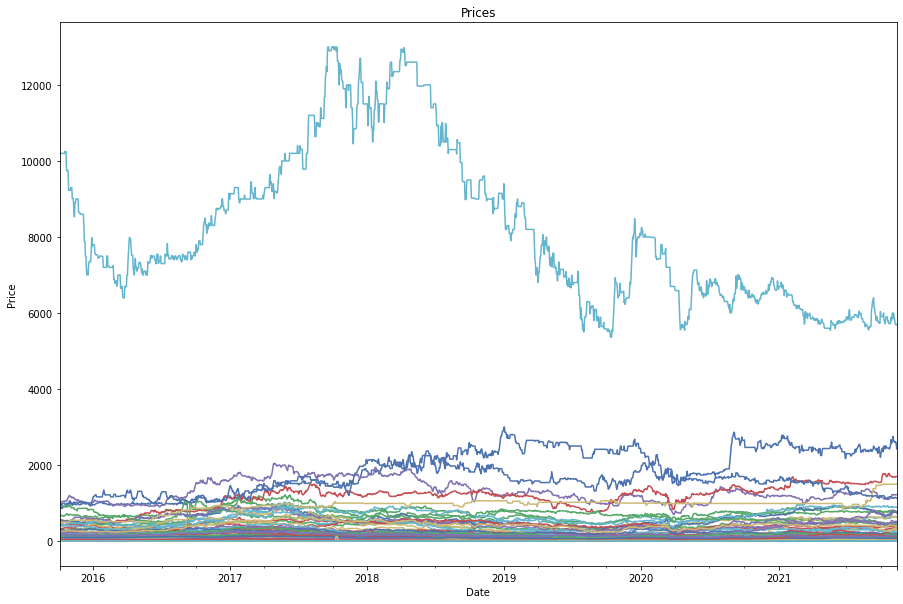

In [5]:
prices.plot(figsize=(15,10),legend=False)
plt.ylabel("Price")
plt.title("Prices");

<br><br><br>

# Hierarchical Risk Parity

Hierarchical Risk Parity is a novel portfolio optimization method developed by Marcos Lopez de Prado. 
Here is a rough overview of how HRP works:

- From a universe of assets, form a distance matrix based on the correlation of the assets.
- Using this distance matrix, cluster the assets into a tree via hierarchical clustering
- Within each branch of the tree, form the minimum variance portfolio (normally between just two assets).
- Combine the mini-portfolios at each node. 

The advantages of this are that it does not require the inversion of the covariance matrix as with traditional mean-variance optimization, and seems to produce diverse portfolios that perform well out of sample. <br> <br> <br> <br>

In [6]:
returns = expected_returns.returns_from_prices(prices).dropna()
hrp = HRPOpt(returns)
hrp.optimize()
weights = renormalize_weights(hrp,cutoff=0.02)
hrp.portfolio_performance(verbose=True,risk_free_rate=0.11);

Expected annual return: 8.5%
Annual volatility: 12.0%
Sharpe Ratio: -0.21


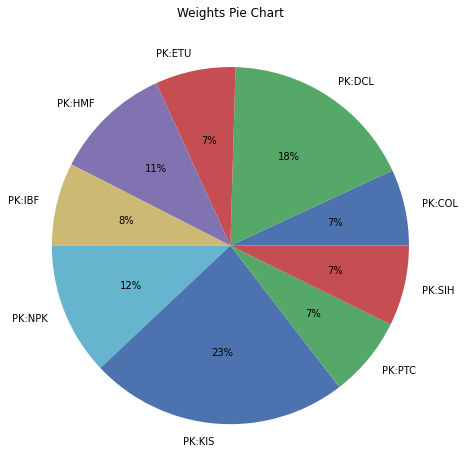

In [7]:
pd.Series(weights).plot.pie(normalize=True,figsize=(8,10),ylabel="",title="Weights Pie Chart",autopct='%1.0f%%');

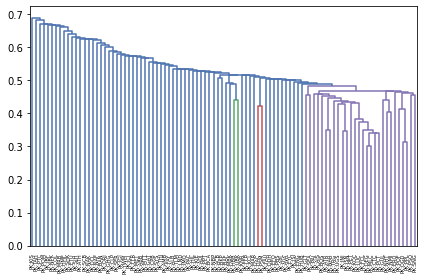

In [8]:
plotting.plot_dendrogram(hrp,show_tickers=True);

# Mean - CVaR

Conditional value at risk is defined as the maximum dollar amount expected to be lost if the wort case scenario occurs, at a pre-defined confidence level. For example, if the 95% one-month VAR is 10,000, there is 95% confidence that over the next month the portfolio will not lose more than 10,000. <br>
- we will use capm model to measure returns
- we will Covariance shirknage method to calculate risk, it is better than simple covariace matrix as it penalizes misspecified values. Covariance estimators without shrinkage are very sensitive to the presence of outliers in the data. Therefore, one should use robust covariance estimators to estimate the covariance of its real data sets. 

Mean and CVaR will be optimized to find the least volatile portfolio. It has been found that min volatilty portfolios tend to outperform max sharpe ratio portfolios. And an efficient frontier will be plotted.

In [9]:
mu      = expected_returns.capm_return(prices,risk_free_rate= 0.11,compounding=True).dropna()
S       = risk_models.CovarianceShrinkage(prices).ledoit_wolf().dropna()

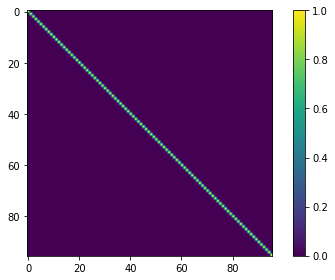

In [10]:
#Plot the covariance matrix
plotting.plot_covariance(S,plot_correlation=True,show_tickers=False);

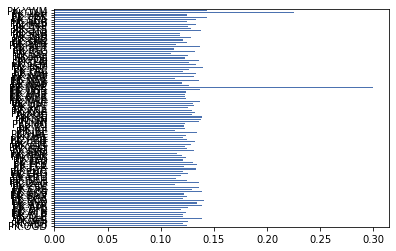

In [11]:
#Plot returns of each stock
mu.plot.barh();

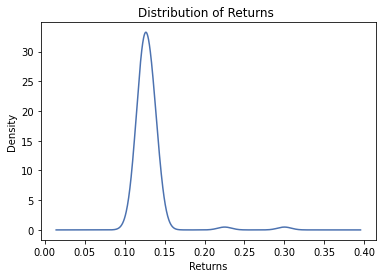

In [12]:
#Check if the returns are normally distributed
mu.plot.density()
plt.xscale("linear")
plt.xlabel("Returns")
plt.title("Distribution of Returns ");

In [13]:
#Optimize 

#Use weight bound (min,max) for box constraints
#Decrease gamma to remove negligible weights


ec = EfficientCVaR(mu, returns,weight_bounds=(0.0,0.25))
ec.add_objective(pypfopt.objective_functions.L2_reg,gamma=0.00001)
ec.min_cvar()
weights = renormalize_weights(ec,cutoff=0.02)
ec.portfolio_performance(verbose=True);

Expected annual return: 11.8%
Conditional Value at Risk: 1.22%


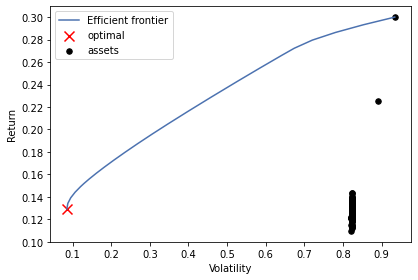

In [14]:
#Plot Efficient Frontier

cla = CLA(mu,S)

cla.min_volatility()
plotting.plot_efficient_frontier(cla,points=500)
plt.locator_params(axis="x", nbins=15)
plt.locator_params(axis="y", nbins=15)

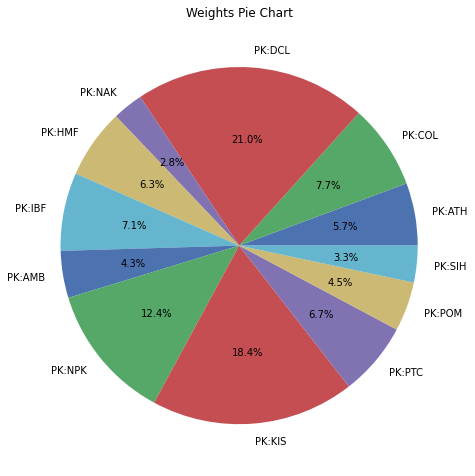

In [15]:
#Plot the optimized weights

pd.Series(weights).plot.pie(normalize=False,figsize=(8,10),ylabel="",title="Weights Pie Chart",autopct='%1.1f%%');